In [31]:
import json
import re
import argparse
import sys
from pathlib import Path
from typing import List, Dict, Tuple

import mne
import numpy as np
from scipy.signal import iirnotch, filtfilt

# ---------------------- CONFIGURATION ----------------------

# OPTION 1: Hardcode your Linux path here if you don't want to use command line args
# Example: Path("/home/username/projects/eeg_data")
HARDCODED_PATH = "dummy" 

# Default settings
TARGET_SFREQ: float = 512.0
TARGET_SECONDS: int = 180
TARGET_SAMPLES: int = int(TARGET_SFREQ * TARGET_SECONDS)
PAD_VALUE: float = 0.0

mne.set_log_level("ERROR")

# ---------------------- PATH SETUP ----------------------
def get_root_path():
    """Determines the root path from CLI args or hardcoded variable."""
    parser = argparse.ArgumentParser(description="Process EEG BDF files.")
    parser.add_argument("--path", type=str, help="Path to the root data directory", default=None)
    
    # Only parse args if running as a script (not in Jupyter)
    if 'ipykernel' in sys.modules:
        args = argparse.Namespace(path=None)
    else:
        args, _ = parser.parse_known_args()

    if args.path:
        return Path(args.path)
    elif HARDCODED_PATH:
        return Path(HARDCODED_PATH)
    else:
        # Fallback: Assume data is in the current directory
        return Path.cwd()

ROOT = get_root_path()

print(f"--- Running on Linux/Unix ---")
print(f"Target Data Directory: {ROOT}")

if not ROOT.exists():
    print(f"\n[ERROR] The path '{ROOT}' does not exist.")
    print("Please edit the 'HARDCODED_PATH' variable in the script")
    print("OR run via terminal: python script.py --path /your/linux/path")
    sys.exit(1)

# ---------------------- HELPERS ----------------------
_num = re.compile(r"(\d+(?:\.\d+)?)")

def parse_powerline(value):
    """Parse PowerLineFrequency into 50 or 60 (handles '50', '50 Hz', [50], etc.)."""
    if value is None:
        return None
    if isinstance(value, (int, float)):
        hz = int(round(float(value)))
        return hz if hz in (50, 60) else None
    if isinstance(value, str):
        m = _num.search(value)
        if m:
            hz = int(round(float(m.group(1))))
            return hz if hz in (50, 60) else None
    if isinstance(value, (list, tuple)) and value:
        return parse_powerline(value[0])
    return None

def notch_filter_array(data: np.ndarray, fs: float, f0: float, Q: float = 35.0, repeats: int = 1) -> np.ndarray:
    """
    Zero-phase IIR notch at f0 (Hz) along the last axis.
    """
    if f0 not in (50.0, 60.0):
        return data
    nyq = fs / 2.0
    if not (0 < f0 < nyq):
        return data
    w0 = f0 / nyq
    b, a = iirnotch(w0, Q)
    out = data
    for _ in range(max(1, repeats)):
        out = filtfilt(b, a, out, axis=-1, padlen=0)
    return out

# ---------------------- DISCOVERY ----------------------
def discover_bdfs(root: Path) -> List[Tuple[str, str, str, Path]]:
    """Return ordered list of (group, subject, session, path). HC first, PD-off, PD-on."""
    # Note: On Linux file systems are case-sensitive. 
    # Ensure 'sub-hc' matches folder names exactly.
    hc_paths = sorted(root.glob("sub-hc*/ses-hc/eeg/*_eeg.bdf"))
    pd_off_paths = sorted(root.glob("sub-pd*/ses-off/eeg/*_eeg.bdf"))
    pd_on_paths  = sorted(root.glob("sub-pd*/ses-on/eeg/*_eeg.bdf"))

    ordered: List[Tuple[str, str, str, Path]] = []
    for p in hc_paths:
        ordered.append(("hc", p.parents[2].name, "ses-hc", p))
    for p in pd_off_paths:
        ordered.append(("pd", p.parents[2].name, "ses-off", p))
    for p in pd_on_paths:
        ordered.append(("pd", p.parents[2].name, "ses-on", p))
    return ordered

ordered = discover_bdfs(ROOT)

if not ordered:
    print(f"\n[ERROR] No .bdf files found under {ROOT}")
    print("Check your directory structure. Linux is case-sensitive.")
    print("Expected structure: {ROOT}/sub-hcXX/ses-hc/eeg/file.bdf")
    sys.exit(1)

print(f"Discovered recordings: {len(ordered)} (HC first, then PD-off, PD-on)")

# ---------------------- CHANNELS ----------------------
def eeg_channels(fname: Path) -> List[str]:
    """Return EEG channel names for a BDF file."""
    raw = mne.io.read_raw_bdf(str(fname), preload=False, verbose="ERROR")
    picks = mne.pick_types(raw.info, eeg=True, eog=False, misc=False, stim=False)
    return [raw.ch_names[i] for i in picks]

# Initialize from first file, then intersect
first_file = ordered[0][3]
common_set = set(eeg_channels(first_file))
if not common_set:
    raise RuntimeError(f"No EEG channels detected in {first_file}")

for _, _, _, p in ordered[1:]:
    chs = set(eeg_channels(p))
    if not chs:
        raise RuntimeError(f"No EEG channels detected in {p}")
    common_set &= chs

if not common_set:
    raise RuntimeError("No common EEG channels across all BDFs. Check montages/labels.")

# Stable order: take order from first file filtered by the intersection
first_order = eeg_channels(first_file)
common_chs = [ch for ch in first_order if ch in common_set]
print(f"Common EEG channels: {len(common_chs)}")

# ---------------------- LOADING & FIXED LENGTH (+ NOTCH) ----------------------
def load_align_fixlen(fname: Path, keep_order: List[str]) -> Tuple[np.ndarray, int]:
    """
    Read BDF, pick only keep_order channels, resample, notch, trim/pad.
    """
    # Sidecar JSON with same basename
    json_path = fname.with_suffix(".json")
    powerline_hz = None
    if json_path.exists():
        try:
            with open(json_path, "r") as f:
                meta = json.load(f)
            powerline_hz = parse_powerline(meta.get("PowerLineFrequency"))
        except Exception:
            powerline_hz = None

    # Print file + powerline
    plf_str = f"{powerline_hz} Hz" if powerline_hz in (50, 60) else "unknown"
    print(f"-> {fname.name} | PowerLineFrequency: {plf_str}")

    raw = mne.io.read_raw_bdf(str(fname), preload=True, verbose="ERROR")

    # Ensure all required channels exist
    missing = [ch for ch in keep_order if ch not in raw.ch_names]
    if missing:
        raise RuntimeError(f"{fname} is missing channels: {missing}")

    # Keep only the agreed EEG channels, in the same order
    raw.pick_channels(keep_order)

    # Real resampling to target fs if needed
    if abs(raw.info["sfreq"] - TARGET_SFREQ) > 1e-6:
        raw.resample(TARGET_SFREQ, npad="auto")

    # Get data and apply notch if we have 50/60 Hz
    data = raw.get_data().astype(np.float32)  # (n_ch, n_samples)
    if powerline_hz in (50, 60):
        data = notch_filter_array(data, fs=TARGET_SFREQ, f0=float(powerline_hz), Q=35.0, repeats=1)

    # Enforce exact length
    n_ch, n = data.shape
    if n >= TARGET_SAMPLES:
        data = data[:, :TARGET_SAMPLES]
    else:
        out = np.full((n_ch, TARGET_SAMPLES), PAD_VALUE, dtype=np.float32)
        out[:, :n] = data
        data = out

    return data, (powerline_hz if powerline_hz in (50, 60) else -1)

# ---------------------- BUILD 3D ARRAY ----------------------
X_list: List[np.ndarray] = []
meta: List[Dict] = []

for grp, subj, sess, p in ordered:
    arr, plf = load_align_fixlen(p, common_chs)  # (n_ch, TARGET_SAMPLES), powerline
    X_list.append(arr)
    meta.append({
        "group": grp,
        "subject": subj,
        "session": sess,
        "path": str(p),
        "PowerLineFrequency": plf,   # 50 / 60 / -1 if missing
    })

X = np.stack(X_list, axis=0)  # (n_rec, n_ch, TARGET_SAMPLES)

print("Final array shape:", X.shape)
print(f"Sampling rate: {TARGET_SFREQ} Hz | Duration per recording: {TARGET_SECONDS} s")
hc_rows = sum(1 for m in meta if m["group"] == "hc")
pd_off_rows = sum(1 for m in meta if m["group"] == "pd" and m["session"] == "ses-off")
pd_on_rows  = sum(1 for m in meta if m["group"] == "pd" and m["session"] == "ses-on")
print(f"Rows -> HC: {hc_rows} | PD-off: {pd_off_rows} | PD-on: {pd_on_rows}")

# ---------------------- (Optional) SAVE ----------------------
# Save location logic: Save in the ROOT directory or current working directory
SAVE_DIR = ROOT if ROOT.is_dir() else Path.cwd()

# np.save(SAVE_DIR / "EEG_X_200s_512Hz_notched.npy", X)
# with open(SAVE_DIR / "EEG_meta.json", "w") as f:
#     json.dump(meta, f, indent=2)
# with open(SAVE_DIR / "EEG_channels.json", "w") as f:
#     json.dump(common_chs, f, indent=2)

--- Running on Linux/Unix ---
Target Data Directory: dummy
Discovered recordings: 46 (HC first, then PD-off, PD-on)
Common EEG channels: 40
-> sub-hc1_ses-hc_task-rest_eeg.bdf | PowerLineFrequency: 60 Hz
-> sub-hc10_ses-hc_task-rest_eeg.bdf | PowerLineFrequency: 60 Hz
-> sub-hc18_ses-hc_task-rest_eeg.bdf | PowerLineFrequency: 60 Hz
-> sub-hc2_ses-hc_task-rest_eeg.bdf | PowerLineFrequency: 60 Hz
-> sub-hc20_ses-hc_task-rest_eeg.bdf | PowerLineFrequency: 60 Hz
-> sub-hc21_ses-hc_task-rest_eeg.bdf | PowerLineFrequency: 50 Hz
-> sub-hc24_ses-hc_task-rest_eeg.bdf | PowerLineFrequency: 60 Hz
-> sub-hc25_ses-hc_task-rest_eeg.bdf | PowerLineFrequency: 50 Hz
-> sub-hc29_ses-hc_task-rest_eeg.bdf | PowerLineFrequency: 60 Hz
-> sub-hc30_ses-hc_task-rest_eeg.bdf | PowerLineFrequency: 60 Hz
-> sub-hc31_ses-hc_task-rest_eeg.bdf | PowerLineFrequency: 50 Hz
-> sub-hc32_ses-hc_task-rest_eeg.bdf | PowerLineFrequency: 50 Hz
-> sub-hc33_ses-hc_task-rest_eeg.bdf | PowerLineFrequency: 60 Hz
-> sub-hc4_ses-hc

In [32]:
# import numpy as np
# from scipy.signal import butter, filtfilt


# def bandpass_filter(data: np.ndarray, fs: float, lowcut: float = 0.5, 
#                     highcut: float = 70.0, order: int = 4) -> np.ndarray:
#     """
#     Apply zero-phase Butterworth bandpass filter.
    
#     Parameters
#     ----------
#     data : np.ndarray
#         EEG array with time on the last axis. Shape: (46, 40, N)
#     fs : float
#         Sampling rate in Hz.
#     lowcut : float
#         Low cutoff frequency in Hz. Default: 0.5 Hz.
#     highcut : float
#         High cutoff frequency in Hz. Default: 70 Hz.
#     order : int
#         Filter order. Default: 4.
        
#     Returns
#     -------
#     np.ndarray
#         Filtered array with the same shape as input.
#     """
#     nyq = fs / 2.0
#     low = lowcut / nyq
#     high = highcut / nyq
    
#     if not (0 < low < 1):
#         raise ValueError(f"lowcut={lowcut} Hz must be between 0 and Nyquist ({nyq} Hz).")
#     if not (0 < high < 1):
#         raise ValueError(f"highcut={highcut} Hz must be between 0 and Nyquist ({nyq} Hz).")
#     if low >= high:
#         raise ValueError(f"lowcut ({lowcut} Hz) must be less than highcut ({highcut} Hz).")
    
#     b, a = butter(order, [low, high], btype='band')
#     filtered = filtfilt(b, a, data, axis=-1)
    
#     return filtered


# # Apply bandpass filter to your data
# # Assuming your variable is called 'data' with shape (46, 40, N)
# data_filtered = bandpass_filter(
#     data=X,
#     fs=512.0,
#     lowcut=0.5,
#     highcut=70.0,
#     order=4
# )

# print(f"Original shape: {X.shape}")
# print(f"Filtered shape: {data_filtered.shape}")
# print("✓ Bandpass filter (0.5-70 Hz) applied successfully!")

In [33]:
# ---------------------- WINDOWING INTO 2s SEGMENTS ----------------------
WINDOW_SECONDS = 2
WINDOW_SAMPLES = int(TARGET_SFREQ * WINDOW_SECONDS)  # 2 * 512 = 1024

n_rec, n_ch, n_samples = X.shape
if n_samples != TARGET_SAMPLES:
    raise ValueError(f"Expected {TARGET_SAMPLES} samples, got {n_samples}")

if TARGET_SAMPLES % WINDOW_SAMPLES != 0:
    raise ValueError(
        f"TARGET_SAMPLES={TARGET_SAMPLES} is not divisible by WINDOW_SAMPLES={WINDOW_SAMPLES}"
    )

N_WINDOWS = TARGET_SAMPLES // WINDOW_SAMPLES  # 92160 / 1024 = 90

print(f"Number of recordings: {n_rec}")
print(f"Channels per recording: {n_ch}")
print(f"Windows per recording: {N_WINDOWS}")
print(f"Samples per window: {WINDOW_SAMPLES}")

# X: (n_rec, n_ch, TARGET_SAMPLES) -> (n_rec, n_ch, N_WINDOWS, WINDOW_SAMPLES)
X_reshaped = X.reshape(n_rec, n_ch, N_WINDOWS, WINDOW_SAMPLES)  # (46, 40, 90, 1024)

# Put windows as second dim: (n_rec, N_WINDOWS, n_ch, WINDOW_SAMPLES)
X_reshaped = np.transpose(X_reshaped, (0, 2, 1, 3))  # (46, 90, 40, 1024)

# Flatten recordings * windows:
# First 90 rows -> recording 0, next 90 -> recording 1, etc.
X_windows = X_reshaped.reshape(n_rec * N_WINDOWS, n_ch, WINDOW_SAMPLES)  # (46*90, 40, 1024)

print("Final windowed array shape:", X_windows.shape)

# ---------------------- (Optional) WINDOW-LEVEL META ----------------------
meta_windows = []
for rec_idx, m in enumerate(meta):
    for w in range(N_WINDOWS):
        mw = dict(m)  # shallow copy
        mw["window_index"] = w
        mw["start_sample"] = int(w * WINDOW_SAMPLES)
        mw["end_sample"] = int((w + 1) * WINDOW_SAMPLES)
        meta_windows.append(mw)

print("Meta windows length:", len(meta_windows))

# ---------------------- (Optional) SAVE ----------------------
# np.save(ROOT / "EEG_X_2s_windows_512Hz.npy", X_windows)
# with open(ROOT / "EEG_meta_2s_windows.json", "w") as f:
#     json.dump(meta_windows, f, indent=2)

Number of recordings: 46
Channels per recording: 40
Windows per recording: 90
Samples per window: 1024
Final windowed array shape: (4140, 40, 1024)
Meta windows length: 4140


In [34]:
X_windows.shape

(4140, 40, 1024)

Modes array shape (patient, channel, time, mode): (1, 40, 1024, 6)
Channel 3 modes shape: (1024, 6)
Channel 4 modes shape: (1024, 6)


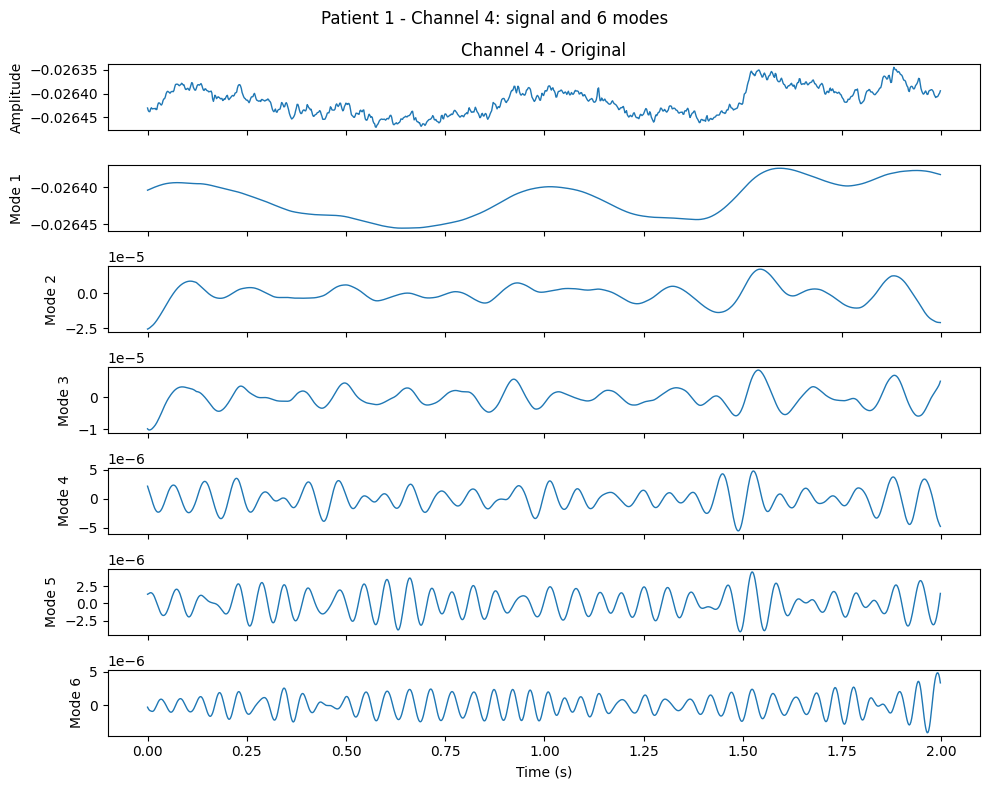

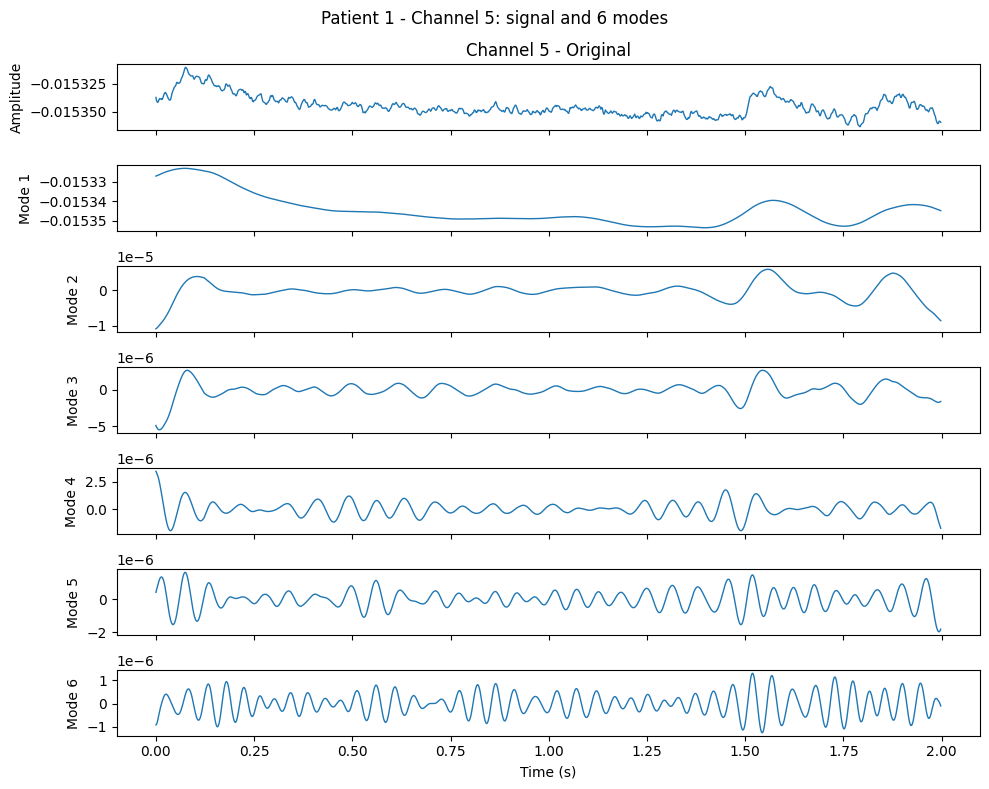

In [35]:
# ---------------------- MDMD-STYLE DECOMPOSITION (FIRST PATIENT ONLY) ----------------------
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt

# Config for MDMD-like decomposition
EMBED_DIM = 64    # L (must be < 1024)
N_MODES   = 6  # number of modes per channel

def build_multichannel_trajectory(window_data: np.ndarray, embed_dim: int):
    """
    Build multichannel Hankel (trajectory) matrix F as in Step 1:
        - For each channel i: Fi (L x K) Hankel
        - Concatenate horizontally: F = [F1 F2 ... FD]  -> (L, D*K)

    window_data: (n_channels, n_samples)
    Returns:
        F : (L, D*K)
        K : number of columns per channel in Fi
    """
    n_ch, N = window_data.shape
    if embed_dim >= N:
        raise ValueError("EMBED_DIM must be smaller than number of samples (N)")

    L = embed_dim
    K = N - L + 1  # number of segments per channel

    hankels = []
    for i in range(n_ch):
        x = window_data[i]  # (N,)
        # sliding_window_view -> (K, L); transpose -> (L, K)
        H_i = sliding_window_view(x, L).T
        hankels.append(H_i)

    # Grand trajectory matrix F: (L, n_ch * K)
    F = np.concatenate(hankels, axis=1)
    return F, K

def diagonal_averaging(H: np.ndarray) -> np.ndarray:
    """
    Diagonal averaging (Hankelisation) to recover a 1D signal from a
    trajectory matrix H (L x K). Output length is N = L + K - 1.
    """
    L, K = H.shape
    N = L + K - 1
    out = np.zeros(N, dtype=H.dtype)
    counts = np.zeros(N, dtype=np.int32)

    for i in range(L):
        for j in range(K):
            out[i + j] += H[i, j]
            counts[i + j] += 1

    out /= counts
    return out

def mdmd_decompose_window(window_data: np.ndarray,
                          embed_dim: int = EMBED_DIM,
                          n_modes: int = N_MODES) -> np.ndarray:
    """
    MDMD-style multichannel decomposition using:
      - Multichannel Hankel embedding
      - SVD of grand trajectory matrix F
      - Rank-1 components + diagonal averaging per channel

    window_data: (n_channels, n_samples)
    Returns:
        modes: (n_channels, n_modes, n_samples)
    """
    n_ch, N = window_data.shape

    # Step 1: Build grand trajectory matrix F
    F, K = build_multichannel_trajectory(window_data, embed_dim)
    L = embed_dim  # rows of F

    # SVD of F: F = U S V^T
    U, s, Vt = np.linalg.svd(F, full_matrices=False)

    # Keep first n_modes components
    r = min(n_modes, U.shape[1])
    U_r = U[:, :r]     # (L, r)
    s_r = s[:r]        # (r,)
    Vt_r = Vt[:r, :]   # (r, n_ch * K)

    modes = np.zeros((n_ch, r, N), dtype=float)

    # For each mode q, construct rank-1 contribution F_q and
    # do diagonal averaging separately per channel.
    for q in range(r):
        F_q = s_r[q] * np.outer(U_r[:, q], Vt_r[q, :])  # (L, n_ch*K)

        for ch in range(n_ch):
            start = ch * K
            end = (ch + 1) * K
            H_ch_q = F_q[:, start:end]  # (L, K) for this channel & mode
            modes[ch, q, :] = diagonal_averaging(H_ch_q)  # (N,)

    return modes  # (n_ch, n_modes, N)


# ---------- APPLY TO FIRST "PATIENT" (FIRST ROW OF ) ----------
# X_windows: shape (46*90, 40, 1024) already created in your previous code
first_patient = X_windows[0]          # (40, 1024)
n_ch, N = first_patient.shape

# Decompose into 5 modes per channel
modes = mdmd_decompose_window(first_patient,
                              embed_dim=EMBED_DIM,
                              n_modes=N_MODES)   # (40, 5, 1024)

# Reshape to (1, 40, 1024, 5) as you wanted
modes_patient1 = np.transpose(modes, (0, 2, 1))   # (40, 1024, 5)
modes_patient1 = modes_patient1[np.newaxis, ...]  # (1, 40, 1024, 5)

print("Modes array shape (patient, channel, time, mode):", modes_patient1.shape)
print("Channel 3 modes shape:", modes_patient1[0, 2].shape)  # (1024, 5)
print("Channel 4 modes shape:", modes_patient1[0, 3].shape)  # (1024, 5)

# ---------------------- PLOT CHANNELS 3 AND 4 ----------------------
time = np.arange(N) / TARGET_SFREQ  # time axis in seconds

for ch_idx in [3, 4]:  # channels 3 and 4 (0-based: 2, 3)
    fig, axes = plt.subplots(N_MODES + 1, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f"Patient 1 - Channel {ch_idx + 1}: signal and {N_MODES} modes")

    # Original channel signal
    axes[0].plot(time, first_patient[ch_idx], linewidth=1.0)
    axes[0].set_ylabel("Amplitude")
    axes[0].set_title(f"Channel {ch_idx + 1} - Original")

    # Each of the 5 modes
    for q in range(N_MODES):
        axes[q + 1].plot(time, modes[ch_idx, q, :], linewidth=1.0)
        axes[q + 1].set_ylabel(f"Mode {q + 1}")

    axes[-1].set_xlabel("Time (s)")
    plt.tight_layout()
    plt.show()


Reconstruction shape (channels, time): (40, 1024)


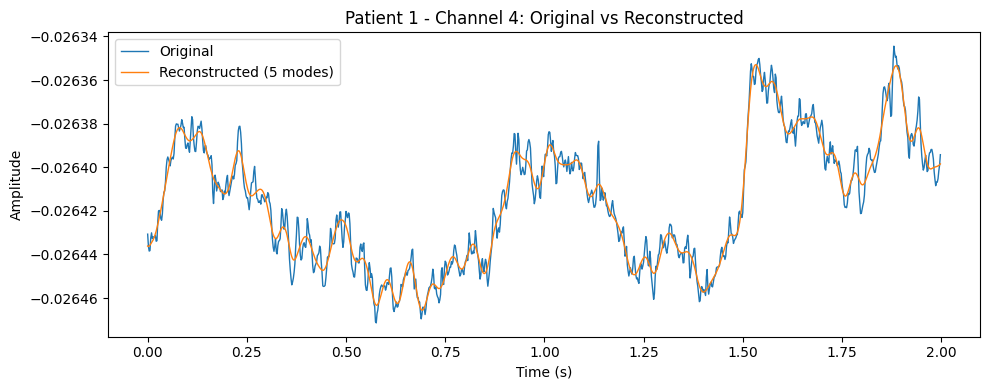

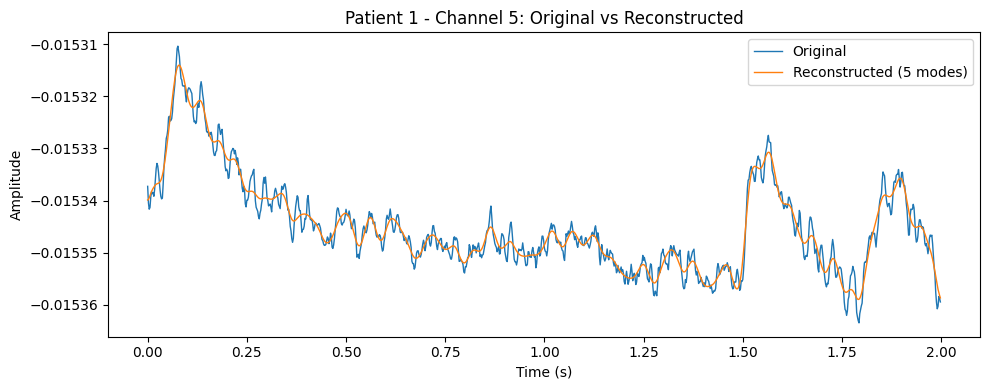

In [36]:
# ---------------------- RECONSTRUCT SIGNAL FROM 5 MODES ----------------------
# Assumes the following are already defined from previous code:
#   - first_patient : np.ndarray with shape (40, 1024)
#   - modes         : np.ndarray with shape (40, 5, 1024)
#   - TARGET_SFREQ  : float (e.g. 512.0 Hz)
#   - matplotlib.pyplot as plt is imported

# In the MDMD / SSA-style decomposition we used, the signal is approximated as
# the sum of all mode components. Since we kept 5 modes, reconstruction is:
#    x_hat_i(t) ≈ sum_{q=1..5} Mode_i(q, t)

# Sum across the mode axis to reconstruct each channel
recon_from_5 = np.sum(modes, axis=1)  # shape: (40, 1024)

print("Reconstruction shape (channels, time):", recon_from_5.shape)

# ---------------------- PLOT ORIGINAL VS RECONSTRUCTED ----------------------
# We now plot for patient 1, channels 2 and 3 (1-based indices -> 0-based 1 and 2)
chan_indices = [3, 4]  # channel 2 and 3
time = np.arange(first_patient.shape[1]) / TARGET_SFREQ  # time axis in seconds

for ch_idx in chan_indices:
    plt.figure(figsize=(10, 4))
    plt.plot(time, first_patient[ch_idx], label="Original", linewidth=1.0)
    plt.plot(time, recon_from_5[ch_idx], label="Reconstructed (5 modes)", linewidth=1.0)
    plt.title(f"Patient 1 - Channel {ch_idx + 1}: Original vs Reconstructed")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [37]:
# # ---------------------- FEATURE EXTRACTION & ML DATAFRAME (PARALLEL) ----------------------
# import numpy as np
# import pandas as pd
# from joblib import Parallel, delayed

# # X_windows: shape (46*90, 40, 1024)
# n_windows, n_ch, N = X_windows.shape
# print("X_windows shape:", X_windows.shape)
# print("Using N_MODES =", N_MODES, "and EMBED_DIM =", EMBED_DIM)

# # ---------- Helper: dominant frequency of one mode ----------
# def dominant_frequency(mode_signal: np.ndarray, fs: float) -> float:
#     """
#     Approximate mode frequency using the dominant FFT bin (excluding DC if possible).
#     """
#     Nsig = mode_signal.size
#     freqs = np.fft.rfftfreq(Nsig, d=1.0 / fs)   # [0, fs/2]
#     spec = np.fft.rfft(mode_signal)
#     mag = np.abs(spec)

#     if mag.size > 1:
#         idx = 1 + np.argmax(mag[1:])  # ignore DC
#     else:
#         idx = 0
#     return float(freqs[idx])

# # ---------- Extract features for a single window ----------
# def extract_features_for_window(window_data: np.ndarray) -> np.ndarray:
#     """
#     window_data: (n_ch, N)
#     Returns: feature vector (n_ch * N_MODES * 3,)
#     Features per (channel, mode): [fq, Pq, Sq]
#     """
#     # modes: (n_ch, N_MODES, N)
#     modes = mdmd_decompose_window(window_data,
#                                   embed_dim=EMBED_DIM,
#                                   n_modes=N_MODES)

#     n_ch_m, n_modes_eff, Nsig = modes.shape
#     assert n_ch_m == n_ch, "Channel count mismatch"
#     assert n_modes_eff == N_MODES, "Mode count mismatch"

#     feats = np.zeros((n_ch_m, n_modes_eff, 3), dtype=float)

#     for ch in range(n_ch_m):
#         for q in range(n_modes_eff):
#             m = modes[ch, q, :]  # (N,)

#             # 1) fq: dominant frequency of mode
#             fq = dominant_frequency(m, TARGET_SFREQ)

#             # 2) Pq: average power
#             Pq = float(np.mean(m ** 2))

#             # 3) Sq: average absolute amplitude
#             Sq = float(np.mean(np.abs(m)))

#             feats[ch, q, 0] = fq
#             feats[ch, q, 1] = Pq
#             feats[ch, q, 2] = Sq

#     # Flatten (n_ch, N_MODES, 3) -> (n_ch * N_MODES * 3,)
#     return feats.reshape(-1)

# # ---------- Parallel feature extraction over all windows ----------
# def _worker(i: int) -> np.ndarray:
#     """
#     Wrapper for parallel extraction so we can log progress.
#     """
#     feats_i = extract_features_for_window(X_windows[i])
#     # simple progress log every 30 windows (and at the last one)
#     if (i + 1) % 30 == 0 or (i + 1) == n_windows:
#         print(f"[joblib] Finished window {i+1}/{n_windows}")
#     return feats_i

# # Use all available cores with n_jobs = -1
# results = Parallel(n_jobs=-1, backend="loky")(
#     delayed(_worker)(i) for i in range(n_windows)
# )

# # Stack to get feature matrix: (n_windows, n_ch * N_MODES * 3)
# X_feat = np.vstack(results)
# print("Feature matrix shape:", X_feat.shape)  # expected (46*90, 40*6*3)

# # ---------- Build column names ----------
# feature_names = []
# for ch in range(n_ch):          # channels 1..40
#     ch_id = ch + 1
#     for q in range(N_MODES):    # modes 1..6
#         mode_id = q + 1
#         feature_names.append(f"ch{ch_id}_mode{mode_id}_fq")
#         feature_names.append(f"ch{ch_id}_mode{mode_id}_Pq")
#         feature_names.append(f"ch{ch_id}_mode{mode_id}_Sq")

# assert len(feature_names) == n_ch * N_MODES * 3

# # ---------- Labels: first 16*90 windows -> 0, others -> 1 ----------
# labels = np.ones(n_windows, dtype=int)
# labels[:16 * 90] = 0

# # ---------- Final ML-ready DataFrame ----------
# df = pd.DataFrame(X_feat, columns=feature_names)
# df["label"] = labels

# print("Final DataFrame shape:", df.shape)
# print(df.head())


import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# ---------------------- 1. CONFIGURATION ----------------------
# Make sure this matches your original path
ROOT = Path("/Users/apple/Desktop/EEG_project/dummy")
csv_path = "features_df.csv"

KERNEL = "linear"
RANDOM_STATE = 213
ROWS_PER_PATIENT = 90
TOTAL_TRAIN = 26
NUM_PATIENTS = 46
TARGET_SFREQ = 512.0

# ---------------------- 2. LOAD FEATURES ----------------------
print(f"Loading features from {csv_path}...")
df = pd.read_csv(csv_path)

# Separate Features and Labels
feature_list = df.drop(columns=["label"]).columns.tolist()
X_full = df.drop(columns=["label"]).to_numpy(float)
y_full = df["label"].to_numpy(int)

print(f"Data loaded. Shape: {X_full.shape}")


# ---------------------- 3. RECREATE PATIENT SPLIT ----------------------
# This logic must match your original training code to ensure 
# X_test contains the same patients.
print("Recreating Train/Test split...")

np.random.seed(RANDOM_STATE)

group1 = np.arange(1, 16 + 1)      # HC patients 1–16
group2 = np.arange(17, 46 + 1)     # PD patients 17–46

n1 = round(TOTAL_TRAIN * 16 / 46)
n2 = TOTAL_TRAIN - n1

train_1 = np.random.choice(group1, size=n1, replace=False)
train_2 = np.random.choice(group2, size=n2, replace=False)

train_patients = np.sort(np.concatenate([train_1, train_2]))
test_patients  = np.setdiff1d(np.arange(1, NUM_PATIENTS + 1), train_patients)

def patient_to_rows(patient_ids):
    idx = []
    for p in patient_ids:
        start = (p - 1) * ROWS_PER_PATIENT
        end = start + ROWS_PER_PATIENT
        idx.extend(range(start, end))
    return idx

train_idx = patient_to_rows(train_patients)
test_idx  = patient_to_rows(test_patients)

X_train, y_train = X_full[train_idx], y_full[train_idx]
X_test,  y_test  = X_full[test_idx],  y_full[test_idx]

print(f"Training patients: {train_patients}")
print(f"Testing patients: {test_patients}")

# ---------------------- 4. RETRAIN MODEL ----------------------
# Training on extracted features is very fast (seconds)
print("Retraining SVM model on features...")

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel=KERNEL, class_weight="balanced",
                probability=False, random_state=RANDOM_STATE, C=0.1)) # Using best param C=0.1
])

pipe.fit(X_train, y_train)
best_model = pipe

print("Model successfully retrained and ready for Counterfactuals!")

# ---------------------- 5. CHECK FOR RAW DATA (Optional) ----------------------
# For the final visualization plots, we need the raw X_windows variable.
# If it's not in memory, we check if it was saved, otherwise warn the user.
if 'X_windows' not in locals():
    npy_path = ROOT / "EEG_X_2s_windows_512Hz.npy"
    if npy_path.exists():
        print(f"Loading raw signal data from {npy_path}...")
        X_windows = np.load(npy_path)
    else:
        print("\n[WARNING]: 'X_windows' (raw EEG signals) is missing from memory and disk.")
        print("You can generate the Counterfactual Features (Math), but you cannot run the")
        print("final 'Native Guide' plotting code without the raw data.")
        print("To fix: Run the first cell of your original notebook (Data Loading) again.")

Loading features from features_df.csv...
Data loaded. Shape: (4140, 720)
Recreating Train/Test split...
Training patients: [ 4  6  7  8  9 11 13 14 15 17 20 22 26 27 29 30 31 32 33 34 35 38 41 42
 43 45]
Testing patients: [ 1  2  3  5 10 12 16 18 19 21 23 24 25 28 36 37 39 40 44 46]
Retraining SVM model on features...
Model successfully retrained and ready for Counterfactuals!


In [39]:
# out_path = ROOT / "outputs" / "features_df.csv"
# out_path.parent.mkdir(parents=True, exist_ok=True)
# df.to_csv(out_path, index=False)
# print("Saved DataFrame to:", out_path)

In [40]:
%pip install pandas
%pip install numpy
%pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


df = pd.read_csv('features_df.csv')

In [42]:
import numpy as np
import pandas as pd
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, roc_auc_score,
    classification_report, confusion_matrix, matthews_corrcoef
)

# ========================================================
# CONFIG
# ========================================================
KERNEL = "linear"
RANDOM_STATE = 213
NUM_PATIENTS = 46
ROWS_PER_PATIENT = 90
TOTAL_TRAIN = 26               # Number of patients used for training

# ========================================================
# LOAD DATA
# ========================================================
X_full = df.drop(columns=["label"]).to_numpy(float)
y_full = df["label"].to_numpy(int)

# ========================================================
# PROPORTIONAL PATIENT-WISE SPLIT
# 16/46 of training patients from first 16
# 30/46 of training patients from next 30
# ========================================================
np.random.seed(RANDOM_STATE)

group1 = np.arange(1, 16 + 1)      # patients 1–16
group2 = np.arange(17, 46 + 1)     # patients 17–46

n1 = round(TOTAL_TRAIN * 16 / 46)   # proportional count for first group
n2 = TOTAL_TRAIN - n1               # proportional count for second group

train_1 = np.random.choice(group1, size=n1, replace=False)
train_2 = np.random.choice(group2, size=n2, replace=False)

train_patients = np.sort(np.concatenate([train_1, train_2]))
test_patients  = np.setdiff1d(np.arange(1, NUM_PATIENTS + 1), train_patients)

def patient_to_rows(patient_ids):
    idx = []
    for p in patient_ids:
        start = (p - 1) * ROWS_PER_PATIENT
        end = start + ROWS_PER_PATIENT
        idx.extend(range(start, end))
    return idx

train_idx = patient_to_rows(train_patients)
test_idx  = patient_to_rows(test_patients)

X_train, y_train = X_full[train_idx], y_full[train_idx]
X_test,  y_test  = X_full[test_idx],  y_full[test_idx]

print("\nTraining patients:", train_patients)
print("Testing patients:", test_patients)
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

# ========================================================
# PIPELINE + GRID SEARCH CV
# ========================================================
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel=KERNEL, class_weight="balanced",
                probability=False, random_state=RANDOM_STATE)),
])

if KERNEL == "linear":
    param_grid = {"clf__C": [0.01, 0.1, 1.0, 10.0, 100.0]}
elif KERNEL == "rbf":
    param_grid = {
        "clf__C": [0.1, 1.0, 10.0, 100.0],
        "clf__gamma": ["scale", 0.1, 0.01, 0.001],
    }
elif KERNEL == "poly":
    param_grid = {
        "clf__C": [0.1, 1.0, 10.0],
        "clf__degree": [2, 3],
        "clf__gamma": ["scale", 0.01],
    }
else:
    param_grid = {"clf__C": [0.1, 1.0, 10.0], "clf__gamma": ["scale", 0.01, 0.001]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=0,
    )
    grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print(f"\nBest params (CV): {grid.best_params_}")
print(f"Best CV ROC-AUC (mean over folds): {grid.best_score_:.4f}")

# ========================================================
# TEST SET EVALUATION (UNSEEN PATIENTS)
# ========================================================
scores_test = best_model.decision_function(X_test)
y_pred = best_model.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
bacc = balanced_accuracy_score(y_test, y_pred)
mcc  = matthews_corrcoef(y_test, y_pred)
try:
    auc = roc_auc_score(y_test, scores_test)
except ValueError:
    auc = np.nan

print("\n============== Test Set Metrics ==============")
print(f"Accuracy:            {acc:.4f}")
print(f"Balanced Accuracy:   {bacc:.4f}")
print(f"ROC-AUC:             {auc:.4f}")
print(f"MCC:                 {mcc:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))



Training patients: [ 4  6  7  8  9 11 13 14 15 17 20 22 26 27 29 30 31 32 33 34 35 38 41 42
 43 45]
Testing patients: [ 1  2  3  5 10 12 16 18 19 21 23 24 25 28 36 37 39 40 44 46]
Train shape: (2340, 720) (2340,)
Test shape: (1800, 720) (1800,)

Best params (CV): {'clf__C': 0.1}
Best CV ROC-AUC (mean over folds): 0.9986

============== Test Set Metrics ==============
Accuracy:            0.7772
Balanced Accuracy:   0.7488
ROC-AUC:             0.8338
MCC:                 0.5045

Confusion Matrix:
[[412 218]
 [183 987]]

Classification Report:
              precision    recall  f1-score   support

           0     0.6924    0.6540    0.6727       630
           1     0.8191    0.8436    0.8312      1170

    accuracy                         0.7772      1800
   macro avg     0.7558    0.7488    0.7519      1800
weighted avg     0.7748    0.7772    0.7757      1800



In [43]:
from sklearn.metrics import confusion_matrix

# Confusion-matrix breakdown on the TEST set
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

print("\n=== Confusion Matrix Breakdown (Test set) ===")
print(f"TN: {tn}   FP: {fp}   FN: {fn}   TP: {tp}")

# Derived rates
eps = 1e-12  # avoid divide-by-zero
tpr = tp / (tp + fn + eps)   # Sensitivity / Recall
tnr = tn / (tn + fp + eps)   # Specificity
fpr = fp / (fp + tn + eps)   # False Positive Rate
fnr = fn / (fn + tp + eps)   # False Negative Rate
ppv = tp / (tp + fp + eps)   # Precision / PPV
npv = tn / (tn + fn + eps)   # Negative Predictive Value

print(f"Sensitivity / Recall (TPR): {tpr:.4f}")
print(f"Specificity (TNR):          {tnr:.4f}")
print(f"False Positive Rate (FPR):  {fpr:.4f}")
print(f"False Negative Rate (FNR):  {fnr:.4f}")
print(f"Precision (PPV):            {ppv:.4f}")
print(f"Negative Predictive Value:  {npv:.4f}")


=== Confusion Matrix Breakdown (Test set) ===
TN: 412   FP: 218   FN: 183   TP: 987
Sensitivity / Recall (TPR): 0.8436
Specificity (TNR):          0.6540
False Positive Rate (FPR):  0.3460
False Negative Rate (FNR):  0.1564
Precision (PPV):            0.8191
Negative Predictive Value:  0.6924


In [44]:

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, matthews_corrcoef,
    confusion_matrix
)

# ---- config (reuse if already defined) ----
try:
    KERNEL
except NameError:
    KERNEL = "linear"
try:
    RANDOM_STATE
except NameError:
    RANDOM_STATE = 42

X = df.drop(columns=["label"]).to_numpy(dtype=float)
y = df["label"].to_numpy(dtype=int)

cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=RANDOM_STATE)

metrics = {
    "acc": [], "bacc": [], "prec": [], "rec": [], "f1": [], "auc": [], "mcc": []
}
TP_total = TN_total = FP_total = FN_total = 0

print("\n===== 7-fold Stratified CV (kernel=%s) =====" % KERNEL)
for fold, (tr, te) in enumerate(cv.split(X, y), start=1):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel=KERNEL, class_weight="balanced", probability=False,
                    random_state=RANDOM_STATE, C=1.0))
    ])
    pipe.fit(X[tr], y[tr])

    y_prob = pipe.decision_function(X[te])  # for AUC
    y_pred = pipe.predict(X[te])

    tn, fp, fn, tp = confusion_matrix(y[te], y_pred, labels=[0, 1]).ravel()
    TP_total += tp; TN_total += tn; FP_total += fp; FN_total += fn

    acc  = accuracy_score(y[te], y_pred)
    bacc = balanced_accuracy_score(y[te], y_pred)
    prec = precision_score(y[te], y_pred, zero_division=0)
    rec  = recall_score(y[te], y_pred, zero_division=0)
    f1   = f1_score(y[te], y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y[te], y_prob)
    except ValueError:
        auc = np.nan
    mcc  = matthews_corrcoef(y[te], y_pred)

    metrics["acc"].append(acc);   metrics["bacc"].append(bacc)
    metrics["prec"].append(prec); metrics["rec"].append(rec)
    metrics["f1"].append(f1);     metrics["auc"].append(auc)
    metrics["mcc"].append(mcc)

    print(f"\n-- Fold {fold} --")
    print(f"TP: {tp}  TN: {tn}  FP: {fp}  FN: {fn}")
    print(f"Acc: {acc:.3f}  BalAcc: {bacc:.3f}  Prec: {prec:.3f}  Rec: {rec:.3f}  F1: {f1:.3f}  AUC: {auc:.3f}  MCC: {mcc:.3f}")

# Macro means ± std
def mstats(v): 
    arr = np.array(v, dtype=float)
    return np.nanmean(arr), np.nanstd(arr)

print("\n===== CV Summary (macro mean ± std over 7 folds) =====")
for k in ["acc","bacc","prec","rec","f1","auc","mcc"]:
    mu, sd = mstats(metrics[k])
    print(f"{k.upper():<5}: {mu:.3f} ± {sd:.3f}")

print("\n===== Confusion Totals (sum over folds) =====")
print(f"TP: {TP_total}  TN: {TN_total}  FP: {FP_total}  FN: {FN_total}")


===== 7-fold Stratified CV (kernel=linear) =====



-- Fold 1 --
TP: 386  TN: 205  FP: 1  FN: 0
Acc: 0.998  BalAcc: 0.998  Prec: 0.997  Rec: 1.000  F1: 0.999  AUC: 1.000  MCC: 0.996

-- Fold 2 --
TP: 386  TN: 206  FP: 0  FN: 0
Acc: 1.000  BalAcc: 1.000  Prec: 1.000  Rec: 1.000  F1: 1.000  AUC: 1.000  MCC: 1.000

-- Fold 3 --
TP: 384  TN: 206  FP: 0  FN: 2
Acc: 0.997  BalAcc: 0.997  Prec: 1.000  Rec: 0.995  F1: 0.997  AUC: 0.997  MCC: 0.993

-- Fold 4 --
TP: 384  TN: 206  FP: 0  FN: 1
Acc: 0.998  BalAcc: 0.999  Prec: 1.000  Rec: 0.997  F1: 0.999  AUC: 1.000  MCC: 0.996

-- Fold 5 --
TP: 385  TN: 206  FP: 0  FN: 0
Acc: 1.000  BalAcc: 1.000  Prec: 1.000  Rec: 1.000  F1: 1.000  AUC: 1.000  MCC: 1.000

-- Fold 6 --
TP: 386  TN: 205  FP: 0  FN: 0
Acc: 1.000  BalAcc: 1.000  Prec: 1.000  Rec: 1.000  F1: 1.000  AUC: 1.000  MCC: 1.000

-- Fold 7 --
TP: 386  TN: 205  FP: 0  FN: 0
Acc: 1.000  BalAcc: 1.000  Prec: 1.000  Rec: 1.000  F1: 1.000  AUC: 1.000  MCC: 1.000

===== CV Summary (macro mean ± std over 7 folds) =====
ACC  : 0.999 ± 0.001
BACC :

Generating Counterfactual for Test Patient Index: 90
Original Decision Score: 0.6104 (Class: 1)
Counterfactual Decision Score: -0.0100 (Class: -1)

--- Top 10 Features to Change to Flip Diagnosis to Healthy ---


,Feature,Original,Counterfactual,Change,Abs_Change
375,ch21_mode6_fq,2.10e+01,2.09e+01,-1.44e-01,1.44e-01
555,ch31_mode6_fq,2.20e+01,2.19e+01,-1.43e-01,1.43e-01
570,ch32_mode5_fq,1.75e+01,1.76e+01,1.43e-01,1.43e-01
369,ch21_mode4_fq,1.35e+01,1.34e+01,-1.34e-01,1.34e-01
669,ch38_mode2_fq,7.00e+00,7.13e+00,1.32e-01,1.32e-01
15,ch1_mode6_fq,2.15e+01,2.16e+01,1.32e-01,1.32e-01
207,ch12_mode4_fq,1.50e+01,1.49e+01,-1.31e-01,1.31e-01
69,ch4_mode6_fq,2.20e+01,2.19e+01,-1.30e-01,1.30e-01
336,ch19_mode5_fq,1.65e+01,1.66e+01,1.27e-01,1.27e-01
393,ch22_mode6_fq,2.10e+01,2.09e+01,-1.16e-01,1.16e-01


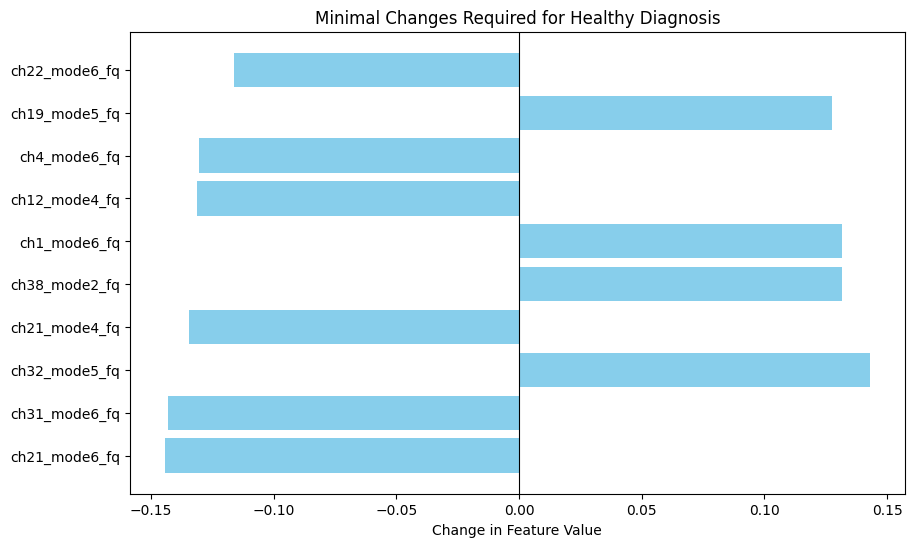

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_counterfactual(model, x_patient, feature_names, epsilon=0.01):
    """
    Generates a counterfactual explanation for a Linear SVM model.
    
    Parameters:
    - model: The trained sklearn Pipeline (StandardScaler + SVC).
    - x_patient: The original input vector (1D numpy array) for the patient.
    - feature_names: List of feature names for interpretation.
    - epsilon: Small margin to ensure the counterfactual pushes past the boundary.
    
    Returns:
    - comparison_df: DataFrame showing Original vs. Counterfactual values.
    """
    
    # 1. Extract Model Parameters
    scaler = model.named_steps['scaler']
    clf = model.named_steps['clf']
    
    # SVM weights (w) and bias (b)
    w = clf.coef_.flatten()
    b = clf.intercept_[0]
    
    # 2. Scale the Input
    # SVM operates in scaled space, so we must project in that space
    z_patient = scaler.transform(x_patient.reshape(1, -1)).flatten()
    
    # 3. Check Current Prediction
    decision_value = np.dot(w, z_patient) + b
    current_class = np.sign(decision_value)
    
    print(f"Original Decision Score: {decision_value:.4f} (Class: {int(current_class)})")
    
    if current_class == -1:
        print("Patient is already classified as Healthy (Class -1). No counterfactual needed.")
        return None

    # 4. Calculate Geometric Counterfactual (The Math)
    # Distance from point to hyperplane: dist = (w.x + b) / ||w||
    # We move in the direction of the normal vector (-w) to minimize L2 distance.
    w_norm_sq = np.dot(w, w)
    
    # Project z onto the hyperplane (w.z + b = 0) and push by epsilon
    # Formula: z_cf = z - (f(z) / ||w||^2) * w  <-- Projection
    # We add epsilon * sign(decision_value) to push it to the other side
    lambda_param = (decision_value + epsilon) / w_norm_sq
    z_cf = z_patient - lambda_param * w
    
    # 5. Verify the Flip
    new_decision_value = np.dot(w, z_cf) + b
    print(f"Counterfactual Decision Score: {new_decision_value:.4f} (Class: {int(np.sign(new_decision_value))})")
    
    # 6. Inverse Scale to Original Units
    x_cf = scaler.inverse_transform(z_cf.reshape(1, -1)).flatten()
    
    # 7. Interpret Results (Challenge 2 & 5: Sparsity & Actionability)
    # Calculate absolute changes
    delta = x_cf - x_patient
    
    # Create a DataFrame for the top changing features
    cf_df = pd.DataFrame({
        'Feature': feature_names,
        'Original': x_patient,
        'Counterfactual': x_cf,
        'Change': delta,
        'Abs_Change': np.abs(delta)
    })
    
    # Sort by magnitude of change (Sparsity focus)
    cf_df = cf_df.sort_values(by='Abs_Change', ascending=False).head(10)
    
    return cf_df

# --- EXECUTION ---

# 1. Select a Patient correctly classified as Parkinson's (Class 1)
# We use the model to predict on X_test and find a positive case
test_preds = best_model.predict(X_test)
positive_indices = np.where(test_preds == 1)[0]

if len(positive_indices) > 0:
    # Pick the first Parkinson's patient in the test set
    idx = positive_indices[0]
    x_input = X_test[idx]
    
    print(f"Generating Counterfactual for Test Patient Index: {idx}")
    
    # Get feature names from the dataframe
    feature_list = df.drop(columns=["label"]).columns.tolist()
    
    # Run the algorithm
    explanation = generate_counterfactual(best_model, x_input, feature_list)
    
    # Display Result
    if explanation is not None:
        print("\n--- Top 10 Features to Change to Flip Diagnosis to Healthy ---")
        display(explanation)
        
        # Optional: Visualize
        plt.figure(figsize=(10, 6))
        plt.barh(explanation['Feature'], explanation['Change'], color='skyblue')
        plt.xlabel("Change in Feature Value")
        plt.title("Minimal Changes Required for Healthy Diagnosis")
        plt.axvline(0, color='black', linewidth=0.8)
        plt.show()
else:
    print("No Parkinson's patients found in test set to generate explanations for.")

Searching database of 1440 Healthy windows for a Guide...
Explaining Patient Window (Global Index: 2212)
Found Nearest Healthy Guide (Global Index: 971, Dist: 558.5664)
Original Score: 26.99 -> Counterfactual Score: -1.35 (Threshold: 0.0)


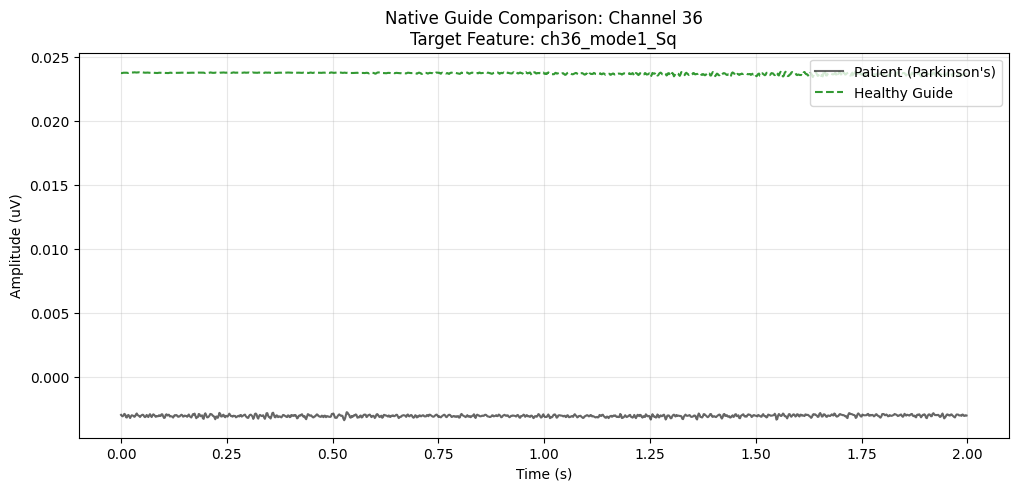


TOP AMPLITUDE (Sq) REDUCTIONS REQUIRED
      Feature  Original  Counterfactual    Change
ch36_mode1_Sq  3.02e-03        2.38e-02  2.08e-02
ch31_mode1_Sq  3.09e-03        2.11e-02  1.80e-02
 ch4_mode1_Sq  2.23e-03        1.71e-02  1.49e-02
ch20_mode1_Sq  3.31e-03        1.77e-02  1.44e-02
ch18_mode1_Sq  1.34e-02        4.67e-03 -8.68e-03

TOP POWER (Pq) REDUCTIONS REQUIRED
      Feature  Original  Counterfactual    Change
ch36_mode1_Pq  9.10e-06        5.65e-04  5.56e-04
ch31_mode1_Pq  9.58e-06        4.42e-04  4.33e-04
ch20_mode1_Pq  1.10e-05        3.13e-04  3.02e-04
 ch4_mode1_Pq  4.96e-06        2.91e-04  2.86e-04
ch34_mode1_Pq  2.81e-04        9.57e-05 -1.85e-04

TOP FREQUENCY (fq) CHANGES REQUIRED
      Feature  Original  Counterfactual    Change
ch24_mode2_fq  7.30e+01        2.18e+00 -7.08e+01
ch15_mode2_fq  7.30e+01        2.69e+00 -7.03e+01
ch14_mode2_fq  7.30e+01        2.69e+00 -7.03e+01
ch12_mode2_fq  7.30e+01        2.69e+00 -7.03e+01
ch40_mode2_fq  7.40e+01        4.69e+

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

# --- 1. Setup & Configuration ---
# Assumes 'best_model', 'X_test', 'df', and 'X_windows' are already loaded
if 'feature_list' not in locals():
    feature_list = df.drop(columns=["label"]).columns.tolist()

# Extract scaler and classifier from the pipeline for manual calculations
scaler = best_model.named_steps['scaler']
clf = best_model.named_steps['clf']
w = clf.coef_.flatten()
b = clf.intercept_[0]

# Separate the "Healthy" population (Target Class 0)
# We must scale these to measure valid distances in the SVM space
healthy_indices = df.index[df['label'] == 0].tolist()
X_healthy_raw = df.drop(columns=['label']).iloc[healthy_indices].to_numpy()
X_healthy_scaled = scaler.transform(X_healthy_raw)

print(f"Searching database of {len(healthy_indices)} Healthy windows for a Guide...")

# --- 2. Find Representative Parkinson's Patient ---
# We look for a patient classified as PD (Class 1)
test_preds = best_model.predict(X_test)
pd_indices = np.where(test_preds == 1)[0]

if len(pd_indices) > 0:
    # Select the most confident PD prediction to demonstrate a robust counterfactual
    scores = best_model.decision_function(X_test[pd_indices])
    target_test_idx = pd_indices[np.argmax(scores)]
    
    # Get the specific window data
    x_input = X_test[target_test_idx] # Original Features (Unscaled)
    z_input = scaler.transform(x_input.reshape(1, -1)).flatten() # Scaled Features
    
    # Retrieve Raw Signal for plotting (mapping back to global index)
    global_idx = test_idx[target_test_idx] 
    x_orig_raw = X_windows[global_idx] 
    
    print(f"Explaining Patient Window (Global Index: {global_idx})")

    # --- 3. Find Native Guide (Nearest Healthy Neighbor) ---
    # We calculate distance in SCALED space to match SVM logic
    #     dists = euclidean_distances(z_input.reshape(1, -1), X_healthy_scaled).flatten()
    
    # Find minimum distance index
    nearest_local_idx = np.argmin(dists)
    nearest_global_idx = healthy_indices[nearest_local_idx]
    
    # Get Guide Data
    x_guide_features = X_healthy_raw[nearest_local_idx] # Unscaled
    z_guide = X_healthy_scaled[nearest_local_idx]       # Scaled
    x_guide_raw_signal = X_windows[nearest_global_idx]  # Raw EEG Signal
    
    print(f"Found Nearest Healthy Guide (Global Index: {nearest_global_idx}, Dist: {dists[nearest_local_idx]:.4f})")

    # --- 4. Generate Guided Counterfactual (Interpolation) ---
    # Instead of projecting geometrically, we slide the patient's data 
    # along the vector towards the healthy guide until the SVM class flips.
    # This ensures the result lies on the "Data Manifold".
    
    # SVM Scores
    score_orig = np.dot(w, z_input) + b
    score_guide = np.dot(w, z_guide) + b
    
    # Calculate alpha (percent distance to travel to hit the boundary)
    # Formula: score_orig + alpha * (score_guide - score_orig) = 0
    alpha = -score_orig / (score_guide - score_orig)
    
    # Add a 5% safety margin to push it just past the boundary into healthy territory
    alpha_final = alpha * 1.05
    
    # Interpolate in Scaled Space
    z_cf = z_input + alpha_final * (z_guide - z_input)
    
    # Inverse Scale to get readable Feature Values
    x_cf = scaler.inverse_transform(z_cf.reshape(1, -1)).flatten()
    
    # Verify the flip
    new_score = np.dot(w, z_cf) + b
    print(f"Original Score: {score_orig:.2f} -> Counterfactual Score: {new_score:.2f} (Threshold: 0.0)")

    # --- 5. Calculate Changes ---
    delta = x_cf - x_input
    
    # Create DataFrame
    full_cf_df = pd.DataFrame({
        'Feature': feature_list,
        'Original': x_input,
        'Counterfactual': x_cf,
        'Change': delta,
        'Abs_Change': np.abs(delta)
    })

    # --- 6. Visualization: Signal Comparison ---
    # Plot the channel with the biggest required change in Amplitude (Sq)
    sq_subset = full_cf_df[full_cf_df['Feature'].str.contains('_Sq')]
    top_feature = sq_subset.sort_values(by='Abs_Change', ascending=False).iloc[0]['Feature']
    
    # Parse channel index from feature name (e.g. "ch12_mode1_Sq")
    parts = top_feature.split('_')
    ch_idx = int(parts[0].replace('ch', '')) - 1
    
    plt.figure(figsize=(12, 5))
    t_axis = np.arange(1024) / 512.0
    
    # Plot Patient vs Guide
    plt.plot(t_axis, x_orig_raw[ch_idx], color='black', alpha=0.6, label="Patient (Parkinson's)")
    plt.plot(t_axis, x_guide_raw_signal[ch_idx], color='green', linestyle='--', alpha=0.8, label="Healthy Guide")
    
    plt.title(f"Native Guide Comparison: Channel {ch_idx+1}\nTarget Feature: {top_feature}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (uV)")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- 7. Print Top Recommendations ---
    print("\n" + "="*40)
    print("TOP AMPLITUDE (Sq) REDUCTIONS REQUIRED")
    print("="*40)
    print(sq_subset.sort_values(by='Abs_Change', ascending=False).head(5)[['Feature', 'Original', 'Counterfactual', 'Change']].to_string(index=False))

    print("\n" + "="*40)
    print("TOP POWER (Pq) REDUCTIONS REQUIRED")
    print("="*40)
    pq_subset = full_cf_df[full_cf_df['Feature'].str.contains('_Pq')]
    print(pq_subset.sort_values(by='Abs_Change', ascending=False).head(5)[['Feature', 'Original', 'Counterfactual', 'Change']].to_string(index=False))

        # --- Filter and Print fq (Frequency) Differences ---
    print("\n" + "="*40)
    print("TOP FREQUENCY (fq) CHANGES REQUIRED")
    print("="*40)

    # Filter for features containing '_fq'
    fq_subset = full_cf_df[full_cf_df['Feature'].str.contains('_fq')].copy()

    # Sort by the absolute magnitude of the change
    print(fq_subset.sort_values(by='Abs_Change', ascending=False).head(10)[['Feature', 'Original', 'Counterfactual', 'Change']].to_string(index=False))

else:
    print("No Parkinson's patients found in the test set to analyze.")